In [1]:
%matplotlib inline

# Data Preparation

### Load CSV using Pandas

In [2]:
import pandas as pd
train = pd.read_csv('../data/kaggle/train.csv')
test = pd.read_csv('../data/kaggle/test.csv')
print(train.shape, test.shape)

(990, 194) (594, 193)


### Label Encoding

In [58]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_train = encoder.fit_transform(train.species)

### Reshape the data

In [95]:
X_train = train.drop(['species'], axis=1).set_index('id', drop=True)
X_train.index.name = None
X_test = test.set_index('id', drop=True)
X_test.index.name = None

### Standard Scaler (regularization)

In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transform_values = lambda df, func: pd.DataFrame(
    func(df.values), 
    columns=df.columns, 
    index=df.index)
X_train_scaled = transform_values(X_train, scaler.fit_transform)
X_test_scaled = transform_values(X_test, scaler.transform)

### Peek the data

In [126]:
cols = ['margin1', 'texture1', 'shape1'] # X_train.columns
train_rows = range(0,4) # range(X_train.shape[0])
test_rows = range(0,4)  # range(X_test.shape[0])
the_merge = lambda a, b, rows: pd.merge(
    a[cols].iloc[rows],
    b[cols].iloc[rows],
    left_index=True,
    right_index=True,
    suffixes=['','_scaled'])

pd.concat([the_merge(X_train, X_train_scaled, train_rows),
           the_merge(X_test,  X_test_scaled, test_rows )],
          keys=['train', 'test'])
           

margin1  texture1    shape1  margin1_scaled  texture1_scaled  \
train 1   0.007812  0.049805  0.000647       -0.486611         0.632907   
      2   0.005859  0.000000  0.000749       -0.585602        -0.498496   
      3   0.005859  0.003906  0.000973       -0.585602        -0.409765   
      5   0.000000  0.023438  0.000453       -0.882575         0.033937   
test  4   0.019531  0.112310  0.000782        0.107387         2.052813   
      7   0.007812  0.057617  0.000534       -0.486611         0.810370   
      9   0.000000  0.013672  0.000712       -0.882575        -0.187914   
      12  0.000000  0.002930  0.000556       -0.882575        -0.431937   

          shape1_scaled  
train 1       -0.340305  
      2        0.037105  
      3        0.859058  
      5       -1.051655  
test  4        0.158548  
      7       -0.756223  
      9       -0.099771  
      12      -0.672555

### Plotting the data

In [129]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = (24, 3)

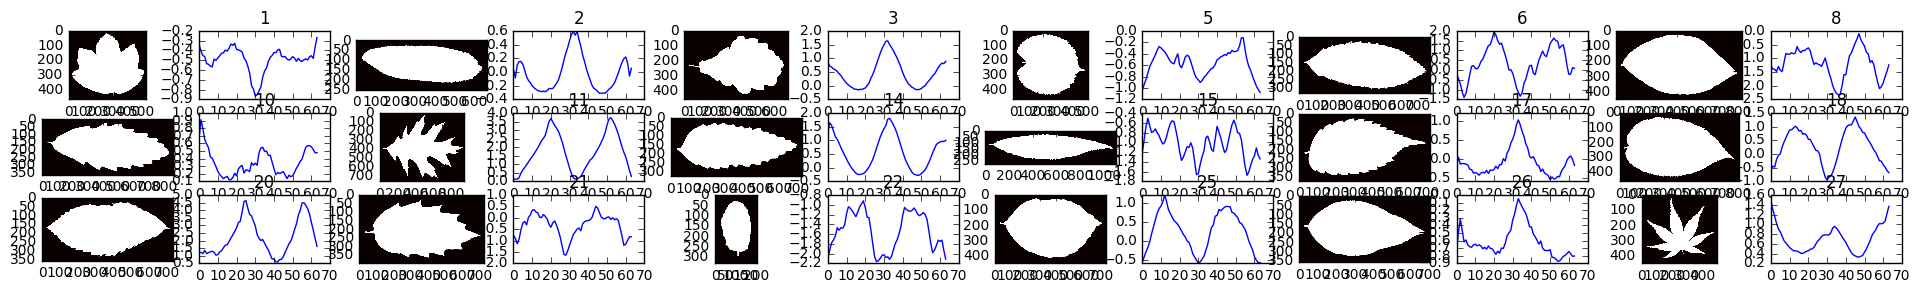

In [130]:
shapes = X_train_scaled.filter(like='shape')
r = 3
c = 6
for i in range(r * c):
    id = shapes.index[i]
    img = mpimg.imread('../data/images/%s.jpg' % id)
    plt.subplot(r, c*2, 2*i + 1)
    plt.imshow(img, cmap='hot')
    plt.subplot(r, c*2, 2*i + 2)
    plt.plot(shapes.values[i])
    plt.title(id)
plt.show()

### Split for Cross Validation

In [131]:
num_fold = 10
cv_rate = 0.1
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(num_fold, test_size=cv_rate, random_state=23)
i = 0
for train_idx, test_idx in sss.split(X_train_scaled, Y_train):
    i+=1
    print("Iteration: %2i" % i, "TRAIN:", len(train_idx), "TEST:", len(test_idx))
#     X_train, X_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
#     y_train, y_test = X_train_scaled[train_idx], X_train_scaled[test_idx]

Iteration:  1 TRAIN: 891 TEST: 99
Iteration:  2 TRAIN: 891 TEST: 99
Iteration:  3 TRAIN: 891 TEST: 99
Iteration:  4 TRAIN: 891 TEST: 99
Iteration:  5 TRAIN: 891 TEST: 99
Iteration:  6 TRAIN: 891 TEST: 99
Iteration:  7 TRAIN: 891 TEST: 99
Iteration:  8 TRAIN: 891 TEST: 99
Iteration:  9 TRAIN: 891 TEST: 99
Iteration: 10 TRAIN: 891 TEST: 99


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(gamma=2, C=1),
    # NuSVC(probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    # GradientBoostingClassifier(),
    GaussianNB(),
    # LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]